In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(z):
    """
    Sigmoid activation function: σ(z) = 1 / (1 + e^(-z))

    Parameters:
    -----------
    z : array-like
        Linear combination of inputs

    Returns:
    --------
    Sigmoid activation values between 0 and 1
    """
    # Clip values to prevent overflow
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))


def compute_cost(X, y, theta, lambda_reg=0):
    """
    Compute logistic regression cost function with optional regularization

    Cost Function:
    J(θ) = -1/m * Σ[y*log(h(x)) + (1-y)*log(1-h(x))] + λ/(2m) * Σθ²

    Parameters:
    -----------
    X : array, shape (m, n)
        Training examples
    y : array, shape (m,)
        True labels (0 or 1)
    theta : array, shape (n,)
        Model parameters
    lambda_reg : float
        Regularization parameter

    Returns:
    --------
    cost : float
        Cost value
    """
    m = len(y)

    # Compute predictions
    h = sigmoid(X @ theta)

    # Add small epsilon to prevent log(0)
    epsilon = 1e-7
    h = np.clip(h, epsilon, 1 - epsilon)

    # Compute cost
    cost = (-1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

    # Add regularization term (excluding bias term theta[0])
    if lambda_reg > 0:
        reg_term = (lambda_reg / (2 * m)) * np.sum(theta[1:] ** 2)
        cost += reg_term

    return cost


def compute_gradient(X, y, theta, lambda_reg=0):
    """
    Compute gradient of cost function

    Gradient:
    ∂J/∂θ = 1/m * X^T * (h(x) - y) + λ/m * θ

    Parameters:
    -----------
    X : array, shape (m, n)
        Training examples
    y : array, shape (m,)
        True labels
    theta : array, shape (n,)
        Model parameters
    lambda_reg : float
        Regularization parameter

    Returns:
    --------
    gradient : array, shape (n,)
        Gradient vector
    """
    m = len(y)

    # Compute predictions
    h = sigmoid(X @ theta)

    # Compute gradient
    gradient = (1 / m) * (X.T @ (h - y))

    # Add regularization (excluding bias term)
    if lambda_reg > 0:
        reg_gradient = (lambda_reg / m) * theta
        reg_gradient[0] = 0  # Don't regularize bias term
        gradient += reg_gradient

    return gradient

In [3]:
# ============================================
# OPTIMIZATION ALGORITHMS
# ============================================

def gradient_descent(X, y, theta, alpha, iterations, lambda_reg=0, verbose=True):
    """
    Gradient Descent Optimization

    Update Rule:
    θ := θ - α * ∇J(θ)

    Parameters:
    -----------
    X : array, shape (m, n)
        Training data
    y : array, shape (m,)
        Labels
    theta : array, shape (n,)
        Initial parameters
    alpha : float
        Learning rate
    iterations : int
        Number of iterations
    lambda_reg : float
        Regularization parameter
    verbose : bool
        Print progress

    Returns:
    --------
    theta : array
        Optimized parameters
    cost_history : list
        Cost at each iteration
    """
    cost_history = []
    theta = theta.copy()

    for i in range(iterations):
        # Compute gradient
        gradient = compute_gradient(X, y, theta, lambda_reg)

        # Update parameters
        theta = theta - alpha * gradient

        # Compute cost
        cost = compute_cost(X, y, theta, lambda_reg)
        cost_history.append(cost)

        # Print progress
        if verbose and (i % 100 == 0 or i == iterations - 1):
            print(f"Iteration {i:4d}: Cost = {cost:.6f}")

    return theta, cost_history


def stochastic_gradient_descent(
    X, y, theta, alpha, epochs, lambda_reg=0, batch_size=1, verbose=True
):
    """
    Stochastic Gradient Descent (SGD) / Mini-batch GD

    Parameters:
    -----------
    X : array, shape (m, n)
        Training data
    y : array, shape (m,)
        Labels
    theta : array, shape (n,)
        Initial parameters
    alpha : float
        Learning rate
    epochs : int
        Number of epochs
    lambda_reg : float
        Regularization parameter
    batch_size : int
        Batch size (1 for SGD, m for batch GD)
    verbose : bool
        Print progress

    Returns:
    --------
    theta : array
        Optimized parameters
    cost_history : list
        Cost at each epoch
    """
    m = len(y)
    cost_history = []
    theta = theta.copy()

    for epoch in range(epochs):
        # Shuffle data
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Mini-batch updates
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i : i + batch_size]
            y_batch = y_shuffled[i : i + batch_size]

            # Compute gradient on batch
            gradient = compute_gradient(X_batch, y_batch, theta, lambda_reg)

            # Update parameters
            theta = theta - alpha * gradient

        # Compute cost on full dataset
        cost = compute_cost(X, y, theta, lambda_reg)
        cost_history.append(cost)

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch:4d}: Cost = {cost:.6f}")

    return theta, cost_history


def newton_method(X, y, theta, iterations=10, lambda_reg=0, verbose=True):
    """
    Newton's Method (Second-order optimization)

    Update Rule:
    θ := θ - H^(-1) * ∇J(θ)
    where H is the Hessian matrix

    Parameters:
    -----------
    X : array, shape (m, n)
        Training data
    y : array, shape (m,)
        Labels
    theta : array, shape (n,)
        Initial parameters
    iterations : int
        Number of iterations
    lambda_reg : float
        Regularization parameter
    verbose : bool
        Print progress

    Returns:
    --------
    theta : array
        Optimized parameters
    cost_history : list
        Cost at each iteration
    """
    m, n = X.shape
    cost_history = []
    theta = theta.copy()

    for i in range(iterations):
        # Compute predictions
        h = sigmoid(X @ theta)

        # Compute gradient
        gradient = compute_gradient(X, y, theta, lambda_reg)

        # Compute Hessian: H = 1/m * X^T * diag(h(1-h)) * X
        D = np.diag(h * (1 - h))
        H = (1 / m) * (X.T @ D @ X)

        # Add regularization to Hessian
        if lambda_reg > 0:
            reg_matrix = (lambda_reg / m) * np.eye(n)
            reg_matrix[0, 0] = 0  # Don't regularize bias
            H += reg_matrix

        # Update parameters: θ := θ - H^(-1) * gradient
        try:
            theta = theta - np.linalg.solve(H, gradient)
        except np.linalg.LinAlgError:
            print("Warning: Singular Hessian matrix, using gradient descent step")
            theta = theta - 0.1 * gradient

        # Compute cost
        cost = compute_cost(X, y, theta, lambda_reg)
        cost_history.append(cost)

        if verbose:
            print(f"Iteration {i:2d}: Cost = {cost:.6f}")

    return theta, cost_history

In [4]:
# ============================================
# LOGISTIC REGRESSION MODEL CLASS
# ============================================


class LogisticRegression:
    """
    Logistic Regression Model

    Parameters:
    -----------
    learning_rate : float
        Learning rate for gradient descent
    iterations : int
        Number of training iterations
    lambda_reg : float
        Regularization parameter (0 = no regularization)
    optimizer : str
        Optimization method ('gd', 'sgd', 'newton')
    batch_size : int
        Batch size for SGD
    verbose : bool
        Print training progress
    """

    def __init__(
        self,
        learning_rate=0.01,
        iterations=1000,
        lambda_reg=0,
        optimizer="gd",
        batch_size=32,
        verbose=True,
    ):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.lambda_reg = lambda_reg
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.verbose = verbose
        self.theta = None
        self.cost_history = []
        self.fitted = False

    def _add_intercept(self, X):
        """Add intercept term (bias) to feature matrix"""
        m = X.shape[0]
        return np.hstack([np.ones((m, 1)), X])

    def fit(self, X, y):
        """
        Train the logistic regression model

        Parameters:
        -----------
        X : array, shape (m, n)
            Training features
        y : array, shape (m,)
            Training labels (0 or 1)

        Returns:
        --------
        self : object
        """
        # Add intercept term
        X_with_intercept = self._add_intercept(X)

        # Initialize parameters
        n_features = X_with_intercept.shape[1]
        self.theta = np.zeros(n_features)

        # Choose optimization method
        if self.optimizer == "gd":
            self.theta, self.cost_history = gradient_descent(
                X_with_intercept,
                y,
                self.theta,
                self.learning_rate,
                self.iterations,
                self.lambda_reg,
                self.verbose,
            )
        elif self.optimizer == "sgd":
            self.theta, self.cost_history = stochastic_gradient_descent(
                X_with_intercept,
                y,
                self.theta,
                self.learning_rate,
                self.iterations,
                self.lambda_reg,
                self.batch_size,
                self.verbose,
            )
        elif self.optimizer == "newton":
            self.theta, self.cost_history = newton_method(
                X_with_intercept,
                y,
                self.theta,
                self.iterations,
                self.lambda_reg,
                self.verbose,
            )
        else:
            raise ValueError(f"Unknown optimizer: {self.optimizer}")

        self.fitted = True
        return self

    def predict_proba(self, X):
        """
        Predict probability estimates

        Parameters:
        -----------
        X : array, shape (m, n)
            Input features

        Returns:
        --------
        probabilities : array, shape (m,)
            Predicted probabilities
        """
        if not self.fitted:
            raise ValueError("Model must be fitted before making predictions")

        X_with_intercept = self._add_intercept(X)
        return sigmoid(X_with_intercept @ self.theta)

    def predict(self, X, threshold=0.5):
        """
        Predict class labels

        Parameters:
        -----------
        X : array, shape (m, n)
            Input features
        threshold : float
            Decision threshold

        Returns:
        --------
        predictions : array, shape (m,)
            Predicted class labels (0 or 1)
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

    def score(self, X, y):
        """
        Calculate accuracy score

        Parameters:
        -----------
        X : array, shape (m, n)
            Input features
        y : array, shape (m,)
            True labels

        Returns:
        --------
        accuracy : float
            Accuracy score
        """
        predictions = self.predict(X)
        return np.mean(predictions == y)

In [5]:
# ============================================
# EVALUATION METRICS
# ============================================


def confusion_matrix(y_true, y_pred):
    """
    Compute confusion matrix

    Returns:
    --------
    cm : array, shape (2, 2)
        [[TN, FP],
         [FN, TP]]
    """
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    return np.array([[TN, FP], [FN, TP]])


def accuracy_score(y_true, y_pred):
    """Calculate accuracy"""
    return np.mean(y_true == y_pred)


def precision_score(y_true, y_pred):
    """Calculate precision: TP / (TP + FP)"""
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    return TP / (TP + FP) if (TP + FP) > 0 else 0.0


def recall_score(y_true, y_pred):
    """Calculate recall: TP / (TP + FN)"""
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP / (TP + FN) if (TP + FN) > 0 else 0.0


def f1_score(y_true, y_pred):
    """Calculate F1 score: 2 * (precision * recall) / (precision + recall)"""
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0


def classification_report(y_true, y_pred):
    """Print classification report"""
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("\n" + "=" * 50)
    print("CLASSIFICATION REPORT")
    print("=" * 50)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("\nConfusion Matrix:")
    print("                Predicted")
    print("              Neg    Pos")
    print(f"Actual Neg  [{cm[0,0]:4d}  {cm[0,1]:4d}]")
    print(f"       Pos  [{cm[1,0]:4d}  {cm[1,1]:4d}]")
    print("=" * 50)

In [6]:
# ============================================
# DATA PREPROCESSING
# ============================================


def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Split data into train and test sets

    Parameters:
    -----------
    X : array, shape (m, n)
        Features
    y : array, shape (m,)
        Labels
    test_size : float
        Proportion of test set
    random_state : int
        Random seed

    Returns:
    --------
    X_train, X_test, y_train, y_test
    """
    if random_state is not None:
        np.random.seed(random_state)

    m = len(y)
    test_size = int(m * test_size)

    # Shuffle indices
    indices = np.random.permutation(m)

    # Split
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


def standardize(X_train, X_test=None):
    """
    Standardize features: z = (x - μ) / σ

    Parameters:
    -----------
    X_train : array
        Training features
    X_test : array, optional
        Test features

    Returns:
    --------
    X_train_scaled, X_test_scaled (if provided)
    """
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    # Avoid division by zero
    std[std == 0] = 1.0

    X_train_scaled = (X_train - mean) / std

    if X_test is not None:
        X_test_scaled = (X_test - mean) / std
        return X_train_scaled, X_test_scaled

    return X_train_scaled

In [7]:
# ============================================
# VISUALIZATION
# ============================================


def plot_decision_boundary(X, y, model, title="Decision Boundary"):
    """
    Plot decision boundary for 2D data

    Parameters:
    -----------
    X : array, shape (m, 2)
        Features (2D only)
    y : array, shape (m,)
        Labels
    model : LogisticRegression
        Fitted model
    title : str
        Plot title
    """
    if X.shape[1] != 2:
        print("Decision boundary plot only available for 2D data")
        return

    # Create mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="RdYlBu", levels=[0, 0.5, 1])

    # Plot data points
    plt.scatter(
        X[y == 0, 0],
        X[y == 0, 1],
        c="blue",
        marker="o",
        edgecolors="k",
        s=80,
        label="Class 0",
    )
    plt.scatter(
        X[y == 1, 0],
        X[y == 1, 1],
        c="red",
        marker="s",
        edgecolors="k",
        s=80,
        label="Class 1",
    )

    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


def plot_cost_history(cost_history, title="Cost Function Over Iterations"):
    """Plot cost function history"""
    plt.figure(figsize=(10, 6))
    plt.plot(cost_history, linewidth=2)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Cost J(θ)", fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


def plot_roc_curve(y_true, y_pred_proba):
    """
    Plot ROC curve

    Parameters:
    -----------
    y_true : array
        True labels
    y_pred_proba : array
        Predicted probabilities
    """
    # Calculate ROC curve points
    thresholds = np.linspace(0, 1, 100)
    tpr_list = []  # True Positive Rate
    fpr_list = []  # False Positive Rate

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)

        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    # Calculate AUC using trapezoidal rule
    auc = np.trapz(tpr_list, fpr_list)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.plot(fpr_list, tpr_list, linewidth=2, label=f"ROC Curve (AUC = {abs(auc):.3f})")
    plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random Classifier")
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC Curve", fontsize=14, fontweight="bold")
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return abs(auc)


# ============================================
# DATA GENERATION
# ============================================


def generate_classification_data(
    n_samples=1000, n_features=2, random_state=None, difficulty="medium"
):
    """
    Generate synthetic binary classification dataset

    Parameters:
    -----------
    n_samples : int
        Number of samples
    n_features : int
        Number of features
    random_state : int
        Random seed
    difficulty : str
        'easy', 'medium', or 'hard'

    Returns:
    --------
    X, y : arrays
        Features and labels
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Generate features
    X = np.random.randn(n_samples, n_features)

    # Generate labels based on difficulty
    if difficulty == "easy":
        # Linearly separable
        weights = np.random.randn(n_features) * 3
        z = X @ weights + np.random.randn(n_samples) * 0.1
    elif difficulty == "medium":
        # Moderately separable
        weights = np.random.randn(n_features) * 2
        z = X @ weights + np.random.randn(n_samples) * 1.0
    else:  # hard
        # Difficult to separate
        weights = np.random.randn(n_features)
        z = X @ weights + np.random.randn(n_samples) * 2.0

    y = (z > 0).astype(int)

    return X, y


LOGISTIC REGRESSION FROM SCRATCH
Pure Mathematical Implementation

Step 1: Generating synthetic dataset...
Dataset shape: (1000, 2)
Class distribution: [523 477]

Step 2: Splitting data into train/test sets...
Training samples: 800
Testing samples: 200

Step 3: Standardizing features...

TRAINING MODELS WITH DIFFERENT OPTIMIZERS

--- Gradient Descent ---
Iteration    0: Cost = 0.682681
Iteration  100: Cost = 0.444120
Iteration  200: Cost = 0.424676
Iteration  300: Cost = 0.420044
Iteration  400: Cost = 0.418588
Iteration  500: Cost = 0.418071
Iteration  600: Cost = 0.417875
Iteration  700: Cost = 0.417798
Iteration  800: Cost = 0.417768
Iteration  900: Cost = 0.417755
Iteration  999: Cost = 0.417750

--- Stochastic Gradient Descent ---
Epoch    0: Cost = 0.668219
Epoch   10: Cost = 0.531504
Epoch   20: Cost = 0.481054
Epoch   30: Cost = 0.457070
Epoch   40: Cost = 0.443804
Epoch   50: Cost = 0.435756
Epoch   60: Cost = 0.430568
Epoch   70: Cost = 0.427071
Epoch   80: Cost = 0.424642
E

/var/folders/jt/gmw9p0p14fb_w8nb69cr8xj40000gn/T/ipykernel_32135/84497132.py:109: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr_list, fpr_list)


Saved: roc_curve.png
AUC Score: 0.8710
Saved: comparison.png

TRAINING COMPLETE!


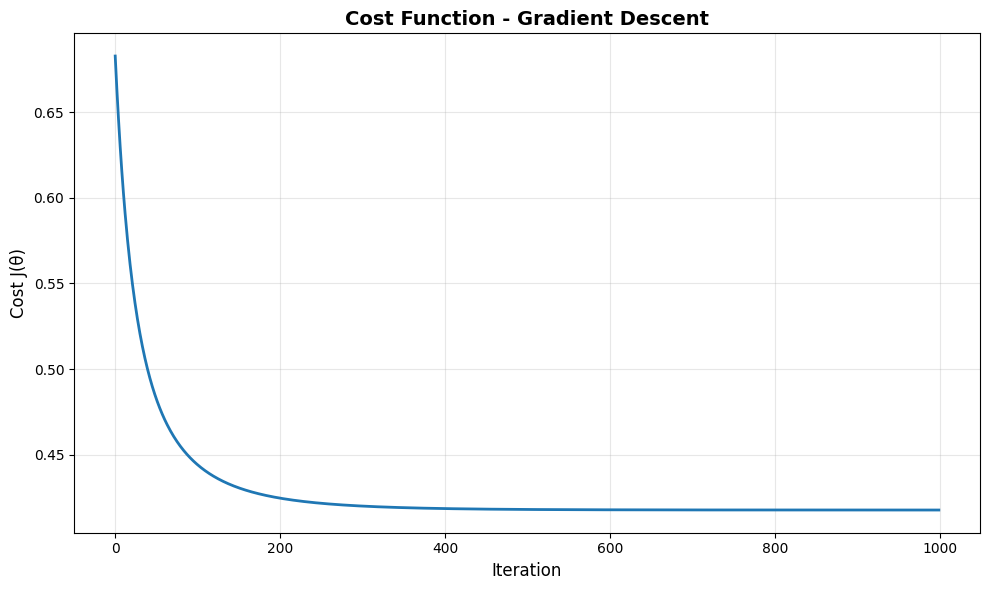

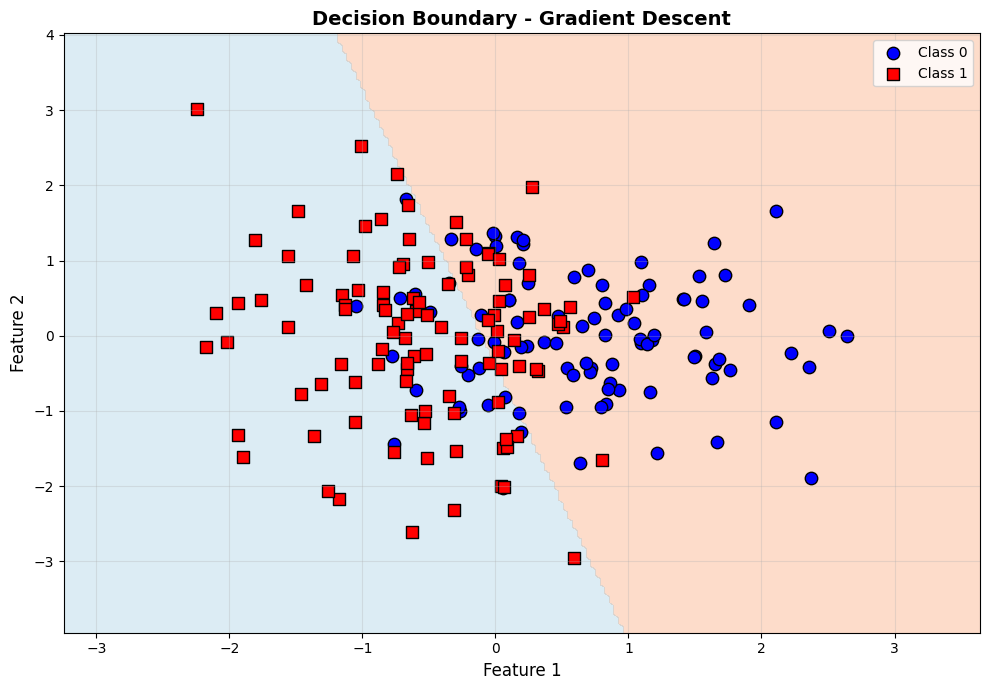

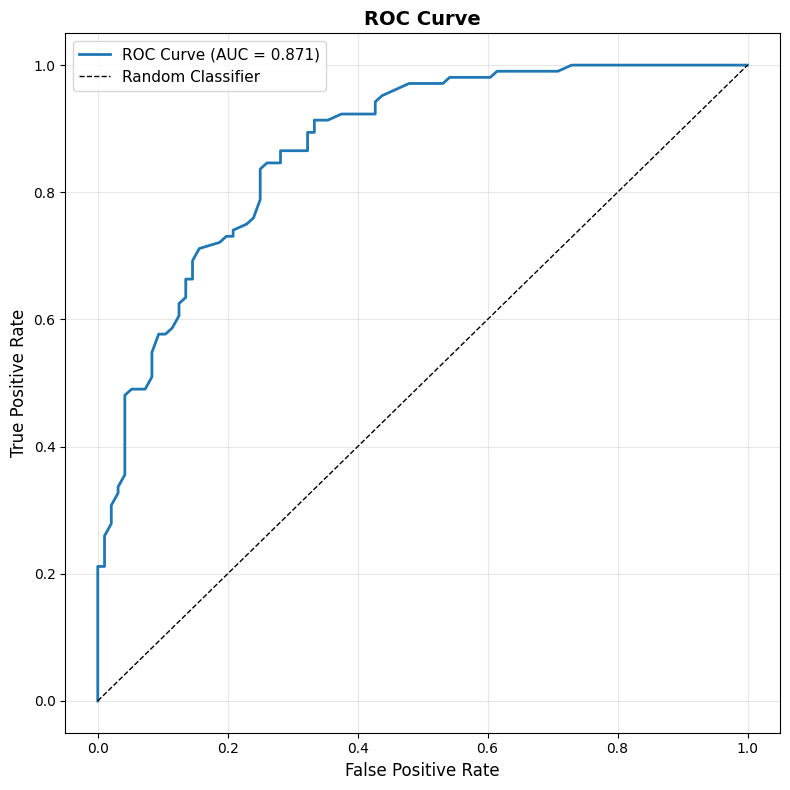

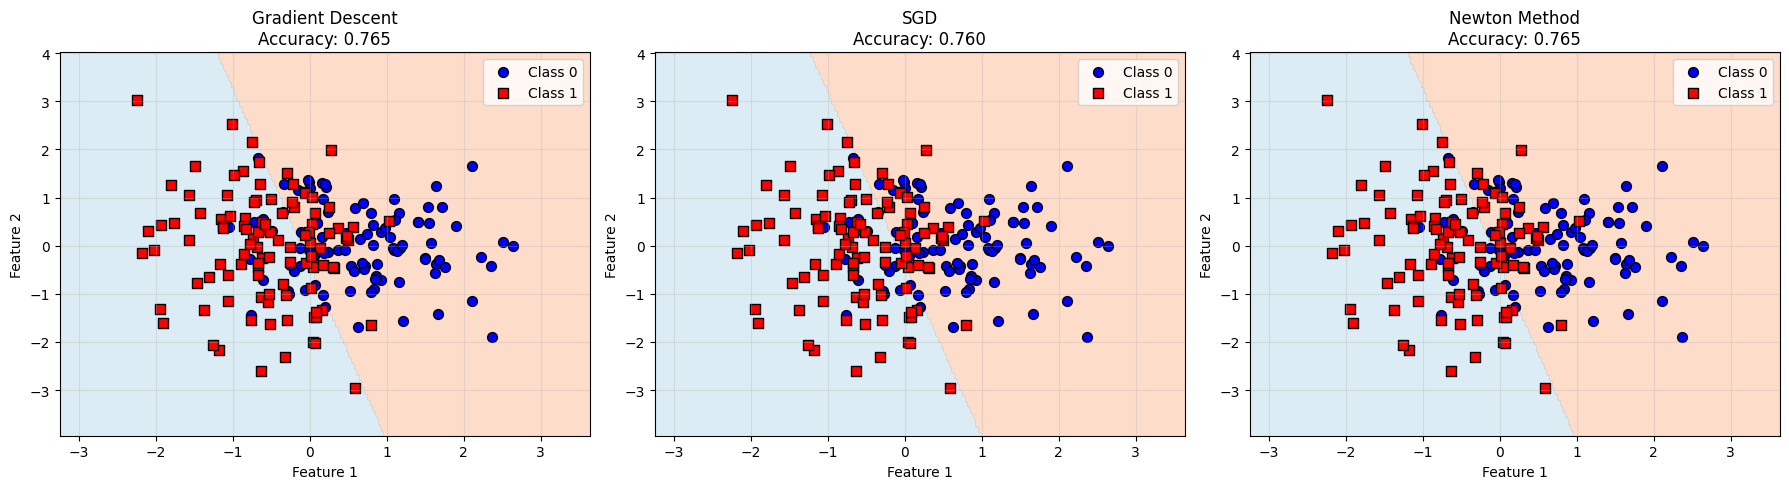

In [ ]:
import numpy as np
import pandas as pd

# ============================================
# EXAMPLE USAGE
# ============================================
import matplotlib.pyplot as plt

def main():
    """Complete example demonstrating logistic regression"""

    print("\n" + "=" * 60)
    print("LOGISTIC REGRESSION FROM SCRATCH")
    print("Pure Mathematical Implementation")
    print("=" * 60 + "\n")

    # 1. Generate synthetic data
    print("Step 1: Generating synthetic dataset...")
    X, y = generate_classification_data(
        n_samples=1000, n_features=2, random_state=42, difficulty="medium"
    )
    print(f"Dataset shape: {X.shape}")
    print(f"Class distribution: {np.bincount(y)}")

    

    # 2. Split data
    print("\nStep 2: Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")

    # 3. Standardize features
    print("\nStep 3: Standardizing features...")
    X_train_scaled, X_test_scaled = standardize(X_train, X_test)

    # 4. Train models with different optimizers
    print("\n" + "=" * 60)
    print("TRAINING MODELS WITH DIFFERENT OPTIMIZERS")
    print("=" * 60)

    # Gradient Descent
    print("\n--- Gradient Descent ---")
    model_gd = LogisticRegression(
        learning_rate=0.1, iterations=1000, optimizer="gd", verbose=True
    )
    model_gd.fit(X_train_scaled, y_train)

    # Stochastic Gradient Descent
    print("\n--- Stochastic Gradient Descent ---")
    model_sgd = LogisticRegression(
        learning_rate=0.01, iterations=100, optimizer="sgd", batch_size=32, verbose=True
    )
    model_sgd.fit(X_train_scaled, y_train)

    # Newton's Method
    print("\n--- Newton's Method ---")
    model_newton = LogisticRegression(iterations=10, optimizer="newton", verbose=True)
    model_newton.fit(X_train_scaled, y_train)

    # 5. Evaluate models
    print("\n" + "=" * 60)
    print("MODEL EVALUATION")
    print("=" * 60)

    for name, model in [
        ("Gradient Descent", model_gd),
        ("SGD", model_sgd),
        ("Newton Method", model_newton),
    ]:
        print(f"\n{'='*50}")
        print(f"{name}")
        print(f"{'='*50}")

        # Training accuracy
        train_acc = model.score(X_train_scaled, y_train)
        print(f"Training Accuracy: {train_acc:.4f}")

        # Test predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)

        # Test metrics
        classification_report(y_test, y_pred)

        # Model parameters
        print(f"\nModel Parameters (θ):")
        print(f"Bias (θ₀): {model.theta[0]:.4f}")
        for i, coef in enumerate(model.theta[1:], 1):
            print(f"θ{i}: {coef:.4f}")

    # 6. Visualizations
    print("\n" + "=" * 60)
    print("GENERATING VISUALIZATIONS")
    print("=" * 60)

    # Cost history
    plot_cost_history(model_gd.cost_history, "Cost Function - Gradient Descent")
    plt.savefig("cost_history.png", dpi=300, bbox_inches="tight")
    print("Saved: cost_history.png")

    # Decision boundary
    plot_decision_boundary(
        X_test_scaled, y_test, model_gd, "Decision Boundary - Gradient Descent"
    )
    plt.savefig("decision_boundary.png", dpi=300, bbox_inches="tight")
    print("Saved: decision_boundary.png")

    # ROC curve
    y_pred_proba = model_gd.predict_proba(X_test_scaled)
    auc = plot_roc_curve(y_test, y_pred_proba)
    plt.savefig("roc_curve.png", dpi=300, bbox_inches="tight")
    print("Saved: roc_curve.png")
    print(f"AUC Score: {auc:.4f}")

    # Comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (name, model) in enumerate(
        [
            ("Gradient Descent", model_gd),
            ("SGD", model_sgd),
            ("Newton Method", model_newton),
        ]
    ):
        ax = axes[idx]

        # Create mesh
        x_min, x_max = X_test_scaled[:, 0].min() - 1, X_test_scaled[:, 0].max() + 1
        y_min, y_max = X_test_scaled[:, 1].min() - 1, X_test_scaled[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200)
        )

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap="RdYlBu", levels=[0, 0.5, 1])
        ax.scatter(
            X_test_scaled[y_test == 0, 0],
            X_test_scaled[y_test == 0, 1],
            c="blue",
            marker="o",
            edgecolors="k",
            s=50,
            label="Class 0",
        )
        ax.scatter(
            X_test_scaled[y_test == 1, 0],
            X_test_scaled[y_test == 1, 1],
            c="red",
            marker="s",
            edgecolors="k",
            s=50,
            label="Class 1",
        )

        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_title(f"{name}\nAccuracy: {model.score(X_test_scaled, y_test):.3f}")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("comparison.png", dpi=300, bbox_inches="tight")
    print("Saved: comparison.png")

    print("\n" + "=" * 60)
    print("TRAINING COMPLETE!")
    print("=" * 60)

    return model_gd, model_sgd, model_newton


if __name__ == "__main__":
    model_gd, model_sgd, model_newton = main()
    plt.show()